##  Modeling the Impact of the canopy shortwave radiation parameterizations on below canopy shortwave radiation in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of the choice of canopy shortwave radiation parameterizations on simulations of below canopy shortwave radiation for three representative water years at the aspen site in the Reynolds Mountain East catchment. This study looked at four different canopy shortwave radiation parameterizations: BeersLaw method(as implemented in VIC), NL_scatter method(Nijssen and Lettenmaier, JGR 1999:NL 1999), UEB_2stream method(Mahat and Tarboton, WRR 2011:MT 2012), CLM_2stream method(Dick 1983)

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. First, the four different canopy shortwave radiation parameteriations are described. Next, the Methods section describes how the pySUMMA can be used to create four different canopy shortwave radiation parameterizations of the Reynolds Mountain East catchment model. The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 1(above) from Clark et al. (2015). 

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

## 2. Background

### Transmission of shortwave radiation through the vegetation canopy available in SUMMA

An important source of predictive differences among hydrologic and land-surface models is the method used to simulate the transmission and attenuation of shortwave radiation through the vegetation canopy. The main inter-model differences stem from (i) the methods used to simulate radiation transmission through homogenous vegetation [Dickinson, 1983; Sellers, 1985; Nijssen and Lettenmaier, 1999; Mahat and Tarboton, 2012]; (ii) the methods used to parameterize the impact of the canopy gap fraction on grid-average shortwave radiation fluxes [Cescatti, 1997; Kucharik et al., 1999; Niu and Yang, 2004; Essery et al., 2008]; and (iii) the methods used to represent spatial variability in vegetation type [Koster and Suarez, 1992; Bonan et al., 2002]. In this paper the parameterizations of canopy shortwave radiation are restricted to radiation transmission through homogenous vegetation, as this approach is used in many existing models. Recent advances in modeling the impact of canopy heterogeneity on grid average fluxes [e.g., Essery et al., 2008] are not included at this stage in model development, and will be considered in future work.

The methods considered for radiation transmission through homogenous vegetation allow for different levels of model complexity. At the simplest level we include an application of Beer’s Law for direct-beam radiation (e.g., as used in VIC). At a more complex level, we include methods that model direct and diffuse beams separately and account for multiple scattering and multiple reflections [Nijssen and Lettenmaier, 1999]. Building additional complexity, we also include options for two-stream radiative transfer models as implemented in UEB [Mahat and Tarboton, 2012] and the Noah-MP model and CLM [Dickinson, 1983; Sellers, 1985; Oleson et al., 2010; Niu et al., 2011].

### 1) Beer's Law

The interception of direct-beam shortwave radiation by vegetation at zenith angle ${\theta}_{zen}$ can be described as [e.g., Mahat and Tarboton, 2012]

\begin{equation*}
\frac{dQ_{swb}}{dz} = -Q_{swb}\frac{G\eta_{l}}{cos({\theta}_{zen})}                   \mspace{200mu}           (1)
\end{equation*}

where ${dQ_{swb}}$ $(W {m}^{-2})$ is the downward shortwave radiation flux for the direct-beam, G (${m}^{2}{m}^{-2}$) is the leaf orientation factor defining the average area of leaves when viewed from direction ${\theta}_{zen}$,   ${\eta_{l}}({m}^{2}{m}^{-3})$ is the leaf+stem density and z(m) is the vertical coordinate, positive downwards.
Given the canopy depth ${D_{can}} = h_{top}^{veg} - h_{bot}^{veg}$ (m), integrating equation (1) results in Beer’s law [Mahat and Tarboton, 2012]

\begin{equation*}
Q_{swb}(D_{can}) = Q_{swb}^{0} exp(-G\frac{\eta_{l} D_{can}}{cos({\theta}_{zen})})                   \mspace{200mu}           (2)
\end{equation*}

where ${dQ_{swb}^{0}}$ $(W {m}^{-2})$ defines the direct-beam shortwave radiation flux at the top of the canopy.

The penetration of direct beam shortwave radiation through the canopy in the absence of scattering can then be described as

\begin{equation*}
\tau_{pb} = \frac{Q_{swb}(D_{can})} {Q_{swb}^{0}} = exp(-G\frac{V_{ex}}{cos({\theta}_{zen})})\mspace{200mu}           (3)
\end{equation*}

where $V_{ex} = {\eta_{l} D_{can}} ({m}^{2}{m}^{-2}) $ defines the total exposed leaf+stem area, that is, the leaf+stem area that is not buried by snow.

Under the simplifying assumption that the total transmission of direct and diffuse radiation (τ) is equal to the penetration of direct beam radiation, i.e.,

\begin{equation*}
\tau = \tau_{pb}\mspace{200mu}           (4)
\end{equation*}

the shortwave radiation flux absorbed by the vegetation canopy and the ground surface is

\begin{equation*}
Q_{swnet}^{veg} = Q_{sw}^{0}(1-\tau)(1-\alpha^{veg})+Q_{sw}^{0} \tau \alpha^{sfc}(1-\tau)\mspace{200mu}           (5)
\end{equation*}

\begin{equation*}
Q_{swnet}^{sfc} = Q_{sw}^{0}\tau(1-\alpha^{sfc})\mspace{200mu}           (6)
\end{equation*}

where ${\alpha^{veg}}$ and $\alpha^{sfc}$(-) define the albedo of the vegetation canopy and ground surface respectively, and $Q_{sw}^{0} = Q_{swb}^{0} + Q_{swd}^{0} (W {m}^{-2})$ is the sum of direct-beam and diffuse radiation at the top of the canopy. Note that ${\alpha^{veg}} $(-) defines the bulk canopy albedo, which is typically much lower than the reflectance of an individual leaf due to the partial trapping of light by layers of leaves [Dickinson, 1983; Nijssen and Lettenmaier, 1999].

The first term on the right-hand-side of equation (5) represents the shortwave radiation absorbed by the canopy on the downward pass, while the second term represents the shortwave radiation that is reflected by the surface and absorbed on the upward pass. The approach described by equations (4) through (6) is similar to that used in the Variable Infiltration Capacity (VIC) model [Liang et al., 1994] and the Distributed Hydrology Soil Vegetation Model (DHSVM) [Wigmosta et al., 1994; Wigmosta and Lettenmaier, 1999], except that (i) VIC and DHSVM do not include a dependence on the solar zenith angle; and (ii) VIC assumes that all radiation reflected by the ground surface is lost through the top of the canopy, i.e., VIC does not include the second term in equation (5), which can be quite important when the ground surface is covered by snow.

### 2) Accounting for diffuse radiation, scattering and multiple reflections (NL_scatter method, Nijssen and Lettenmaier, 1999)

The approach described above assumes all radiation is from a single direct beam and ignores the effects of scattering and multiple reflections. Nijssen and Lettenmaier [1999] showed that the penetration of diffuse radiation, $\tau_{pd}$, can be obtained by integrating over the upper hemisphere, as

\begin{equation*}
\tau_{pd} = \frac{1}{Q_{swd}^{0}} \int_{\Omega} {Q_{swd}^{0}}({\theta}_{zen}) \tau_{pb} ({\theta}_{zen}) cos({\theta}_{zen}) d\Omega \mspace{200mu}           (7)
\end{equation*}

where ${Q_{swd}^{0}}({\theta}_{zen})$ is the above-canopy diffuse-beam radiation from the direction ${\theta}_{zen}$, and $\tau_{pb} ({\theta}_{zen})$ is the direct beam transmissivity from the direction ${\theta}_{zen}$ as defined in equation (16).

Assuming diffuse radiation is isotropic, a solution to equation (20) is [Nijssen and Lettenmaier, 1999; Mahat and Tarboton, 2012]

\begin{equation*}
\tau_{pd} = \frac{Q_{swb}(D_{can})} {Q_{swb}^{0}} = (1-GV_{ex})exp(-GV_{ex})+(GV_{ex})^2E_{i}(1,GV_{ex}) \mspace{200mu}           (8)
\end{equation*}

where $E_{i}(n,x) $ is the exponential integral, and recall that $V_{ex}={\eta_{l} D_{can}}$ defines the total exposed leaf+stem area (${m}^{2}{m}^{-2}$), that is, the leaf+stem area that is not buried by snow.
The total penetration of radiation through the canopy is then

\begin{equation*}
\tau_{pbd} = \frac{Q_{swb}^{0}}{Q_{sw}^{0}}\tau_{pb} + \frac{Q_{swd}^{0}}{Q_{sw}^{0}}\tau_{pd} \mspace{200mu}           (9)
\end{equation*}

where $\tau_{pb} $ is given by the solution to Beer’s law in equation (3).

Nijssen and Lettenmaier [1999] introduce a simple method to account for scattering and multiple reflections, providing total transmission $\tau$ as

\begin{equation*}
\tau = (\tau_{pbd})^{\varnothing_{s}}  \mspace{200mu}           (10)
\end{equation*}

where the exponent ${\varnothing_{s}}$ accounts for scattering of radiation within the vegetation canopy. The value of ${\varnothing_{s}}$  should generally fall in the range 0.7 to 0.85, and ${\varnothing_{s}}$ = 0.81 in the simulations presented by Nijssen and Lettenmaier [1999].

Given equation (10) and the assumption that all shortwave radiation reflected by the ground surface is diffuse, the shortwave radiation flux absorbed by the vegetation canopy and the ground surface can be given as

\begin{equation*}
Q_{swnet}^{veg} = Q_{sw}^{0}(1-\tau)(1-\alpha^{veg})+Q_{sw}^{0} m_{r} \tau \alpha^{sfc}(1-(\tau_{pd})^{\varnothing_{s}}) \mspace{200mu}           (11)
\end{equation*}

\begin{equation*}
Q_{swnet}^{sfc} = Q_{sw}^{0} m_{r} \tau(1-\alpha^{sfc}) \mspace{200mu}           (12)
\end{equation*}

where the terms on the right-hand-side of equation (11) describe the downward and upward radiation absorbed by the vegetation canopy, respectively, and $m_{r}$ accounts for multiple reflections between the ground and canopy.

Note that equation (11) assumes that all reflected radiation is diffuse, and reflection of upward radiation from the canopy is incorporated in the calculation of $\tau$ in equation (10) through the multiple reflection factor $m_{r}$.

The multiple reflection factor $m_{r}$ is derived from the infinite series of reflections between the surface and vegetation [Nijssen and Lettenmaier, 1999] as

\begin{equation*}
m_{r} = \sum_{i=0}^{\infty}[\alpha^{sfc}\alpha^{veg}(1-(\tau_{pd})^{\varnothing_{s}})]^{i} = \frac{1}{1-\alpha^{sfc}\alpha^{veg}(1-(\tau_{pd})^{\varnothing_{s}})}                       \mspace{200mu}           (13)
\end{equation*}

with the factor $(1-(\tau_{pd})^{\varnothing_{s}})$ included to represent the fraction of radiation transmitted and scattered upwards through the canopy [see also Mahat and Tarboton, 2012].

### 3) Two-stream radiative transfer models (UEB_2stream method, Mahat and Tarboton, 2012)

Mahat and Tarboton [2012] describe a two stream radiative transfer model based on the assumptions that radiation is scattered equally in an upward and downward direction and that scattering is along the same path as the incoming radiation. These assumptions yield

\begin{equation*}
- \frac{dU_{sw}}{dz} = \frac{G\eta_{l}}{cos({\theta}_{zen})}[-U_{sw} + \alpha_{leaf} \frac{U_{sw}+Q_{sw}}{2}]      \mspace{200mu}           (14)    
\end{equation*}

\begin{equation*}
- \frac{dQ_{sw}}{dz} = \frac{G\eta_{l}}{cos({\theta}_{zen})}[-Q_{sw} + \alpha_{leaf} \frac{U_{sw}+Q_{sw}}{2}]      \mspace{200mu}           (15)    
\end{equation*}

where $\alpha_{leaf}$  (-) is the leaf scattering coefficient, distinguished from the bulk canopy albedo used in equation (5) and (11), and $U_{sw}$ and $Q_{sw}$ $(W {m}^{-2})$ are the intensity of the upward and downward beams.
The solution for transmission over an infinitely deep canopy is [Mahat and Tarboton, 2012]

\begin{equation*}
\tau_{deep,b} = \frac{Q_{swb}(D_{can})} {Q_{swb}^{0}} = exp(-k^{'}G\frac{V_{ex}}{cos{\theta}_{zen}}) \mspace{200mu}           (16)
\end{equation*}

\begin{equation*}
\tau_{deep,d} = \frac{Q_{swd}(D_{can})} {Q_{swd}^{0}} = (1-k^{'}GV_{ex})exp(-k^{'}GV_{ex})+(k^{'}GV_{ex})^2E_{i}(1,k^{'}GV_{ex}) \mspace{200mu}           (17)
\end{equation*}

where $ k^{'} = \sqrt{1-\alpha_{leaf}} $ Equations (16) and (17) are similar to the expressions in equations (3) and (8), except the factor $ k^{'}$ is included to account for the effects of multiple scattering. Recall that $V_{ex}={\eta_{l}}D_{can}$.

The upward reflection factor $\alpha_{deep}^{veg} $ giving the fraction of radiation reflected from a deep canopy with multiple scattering is

\begin{equation*}
\alpha_{deep}^{veg} = \frac{U_{sw}(z)}{Q_{sw}(z)} = \frac{1-k^{'}}{1+k^{'}}       \mspace{200mu}           (18)    
\end{equation*}

Mahat and Tarboton [2012] use the principle of superposition to derive solutions for a finite canopy, as

\begin{equation*}
\tau_{b} = \frac{Q_{swb}(D_{can})} {Q_{swb}^{0}} = \frac{\tau_{deep,b}[1-(\alpha_{deep}^{veg})^2]}{1-(\alpha_{deep}^{veg})^{2}(\tau_{deep,b})^2} \mspace{200mu}           (19)
\end{equation*}

\begin{equation*}
\alpha_{b}^{veg} = \frac{U_{swb}^{0}} {Q_{swb}^{0}} = \frac{\alpha_{deep}^{veg}[1-(\tau_{deep,b})^2]}{1-(\alpha_{deep}^{veg})^{2}(\tau_{deep,b})^2} \mspace{200mu}           (20)
\end{equation*}

where $\tau_{b}$ and $\alpha_{b}^{veg}$ define the transmittance and reflectance for direct-beam radiation. Equations (19) and (20) can also be used to obtain $\tau_{d}$ and $\alpha_{d}^{veg}$ by replacing the direct transmittance $\tau_{deep,b}$ with the diffuse transmittance $\tau_{deep,d}$ [Mahat and Tarboton, 2012].

The shortwave radiation flux absorbed by the vegetation canopy and the ground surface can now be given as (now distinguishing between direct and diffuse surface albedo, $\alpha_{b}^{sfc}$ and $\alpha_{d}^{sfc}$, as defined in the next section),

\begin{equation*}
Q_{swnet}^{veg} = [Q_{swb}^{0}(1-\tau_{b})(1-\alpha^{veg}_{b})+Q_{swd}^{0}(1-\tau_{d})(1-\alpha^{veg}_{d}] + (Q_{swb}^{0}\tau_{b}\alpha_{b}^{sfc}+Q_{swd}^{0}\tau_{d}\alpha_{d}^{sfc})m_{r}(1-\tau_{d}) \mspace{50mu}           (21)
\end{equation*}

\begin{equation*}
Q_{swnet}^{sfc} = [Q_{swb}^{0}\tau_{b}(1-\alpha^{sfc}_{b})+Q_{swd}^{0}(\tau_{d})(1-\alpha^{sfc}_{d})]m_{r} \mspace{200mu}           (22)
\end{equation*}

where $m_{r}$ is the multiple reflections factor as defined in equation (13) but computed using diffuse reflectances and defined as $m_{r} = [1-\alpha_{d}^{veg}\alpha_{d}^{sfc}(1-\tau_{d})]^{-1}$ . As in equation (11) it is assumed that all upward radiation is diffuse.

We also consider the two-stream radiative transfer model of Dickinson [1983] and Sellers [1985], as implemented in both the Community Land Model [Oleson et al., 2010] and the Noah-MP model [Niu et al., 2011]. In this approach fluxes are computed separately for visible and near-infra-red wavelengths. Complete algorithmic details are provided by Oleson et al. [2010] and are not repeated here.

The above description are taken from the Stomal Resistance Method section within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Install pySUMMA from GitHub (UVA-Hydroinformatics/pysumma-develop branch)

In [ ]:
# On HydroShare, pySUMMA installed, so users don't need to install pySUMMA.
# !/opt/conda/bin/pip install git+https://github.com/uva-hydroinformatics/pysumma.git@develop

### 2) Download SUMMA Model Instance from HydroShare

In [1]:
from pysumma.utils import utils

In [2]:
# Download SUMMA Model Instance from HydroShare
resource_id = '0c4fd861a9694b2f9fcdf19eb33a6b54'
instance = utils.download_model_instance(resource_id)

In [ ]:
!cd SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/; chmod +x ./installTestCases_local.sh
!cd SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/; ./installTestCases_local.sh

### 3) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [3]:
from ipyleaflet import Map, GeoJSON
import json, os

In [4]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open(os.getcwd() + '/' + instance + '/data/reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### 4) Create pySUMMA Simulation Object

In [5]:
from pysumma.Simulation import Simulation

In [6]:
# path to the SUMMA filemanager file
file_manager = os.getcwd() + '/' + instance + '/settings/summa_fileManager_riparianAspenBeersLaw.txt'

In [7]:
# Create pySUMMA Simulation Object
S = Simulation(file_manager)

ModelOuput master file filepath: /home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/meta/var_lookup.f90


### 4) Run SUMMA for the different canopy shortwave radiation parameterizations options

In [8]:
# check the simulation start and finish times
S.decision_obj.simulStart.value, S.decision_obj.simulFinsh.value

('2005-07-01 00:00', '2008-09-30 00:00')

In [9]:
# query for the available canopy shortwave radiation parameterizations
S.decision_obj.canopySrad.options

['noah_mp', 'CLM_2stream', 'UEB_2stream', 'NL_scatter', 'BeersLaw']

#### 5.1) Set BeersLaw method (as implemented in VIC)

In [10]:
S.decision_obj.canopySrad.value = 'BeersLaw'
S.decision_obj.canopySrad.value

'BeersLaw'

#### 5.2) run the model with giving the output prefix "BeersLaw"

In [11]:
S.output_prefix.value = "BeersLaw"

In [12]:
S.executable = "/code/bin/summa.exe"
results_BeersLaw, out_file1 = S.execute(run_suffix="BeersLaw", run_option = 'local')

/home/jovyan/libs/specworker/__init__.py:4: Warning: The SPECS library is in beta development, use at your own risk.
  warnings.warn("The SPECS library is in beta development, use at your own risk.", Warning)


Job finished                                           
task complete
file_master is '/tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_fileManager_riparianAspenBeersLaw.txt_tmp'.
start at 18:47:04
Name of Model Output control file: /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/meta/Model_Output.txt
decisions file =  /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_zDecisions_riparianAspenBeersLaw.txt
   1 simulStart: 2005-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBe

#### 5.3) repeat for the NL_scatter method (Nijssen and Lettenmaier, 1999) 

In [14]:
S.decision_obj.canopySrad.value = 'NL_scatter'
S.decision_obj.canopySrad.value

'NL_scatter'

In [15]:
S.output_prefix.value = "NL_scatter"

In [16]:
S.executable = "/code/bin/summa.exe"
results_NL_scatter, out_file2 = S.execute(run_suffix="NL_scatter", run_option = 'local')

Job finished                                           
task complete
file_master is '/tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_fileManager_riparianAspenBeersLaw.txt_tmp'.
start at 18:47:32
Name of Model Output control file: /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/meta/Model_Output.txt
decisions file =  /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_zDecisions_riparianAspenBeersLaw.txt
   1 simulStart: 2005-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBe

#### 5.4) repeat for the UEB_2stream method (Mahat and Tarboton, 2012)

In [18]:
S.decision_obj.canopySrad.value = 'UEB_2stream'
S.decision_obj.canopySrad.value

'UEB_2stream'

In [19]:
S.output_prefix.value = "UEB_2stream"

In [20]:
S.executable = "/code/bin/summa.exe"
results_UEB_2stream, out_file3 = S.execute(run_suffix="UEB_2stream", run_option = 'local')

Job finished                                           
task complete
file_master is '/tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_fileManager_riparianAspenBeersLaw.txt_tmp'.
start at 18:47:59
Name of Model Output control file: /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/meta/Model_Output.txt
decisions file =  /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_zDecisions_riparianAspenBeersLaw.txt
   1 simulStart: 2005-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBe

#### 5.5) repeat for the CLM_2stream method (Dick, 1983)

In [22]:
S.decision_obj.canopySrad.value = 'CLM_2stream'
S.decision_obj.canopySrad.value

'CLM_2stream'

In [23]:
S.output_prefix.value = "CLM_2stream"

In [24]:
S.executable = "/code/bin/summa.exe"
results_CLM_2stream, out_file4 = S.execute(run_suffix="CLM_2stream", run_option = 'local')

Job finished                                           
task complete
file_master is '/tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_fileManager_riparianAspenBeersLaw.txt_tmp'.
start at 18:48:27
Name of Model Output control file: /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/meta/Model_Output.txt
decisions file =  /tmp/summa/home/jovyan/work/notebooks/data/c1bb4a12bff44bf08c5958cba7947348/c1bb4a12bff44bf08c5958cba7947348/data/contents/SummaModel_ReynoldsAspenStand_ShortwaveRadiation_sopron/settings/summa_zDecisions_riparianAspenBeersLaw.txt
   1 simulStart: 2005-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBe

## 4. Results

### Recreate the Figure 1 plot from Clark et al., 2015: The Impact of the canopy shortwave radiation parameterizations on below canopy shortwave radiation

In [26]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
#import matplotlib.pyplot as plt
import pandas as pd
jtplot.figsize(x=10, y=10)

#### 4.1) Create function to calculate below canopy shortwave radiation from SUMMA output

In [27]:
# get output netCDF and resample data by the average for hour of day
def calc_short_radiation(rad_output_df, start_time, end_time):
    # get 'solar radiation transmitted below the canopy' data from output netCDF, unit : Wm-2
    short_radiation_data = rad_output_df['scalarBelowCanopySolar']
    # create dates(X-axis) attribute from ouput netcdf
    dates = short_radiation_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = short_radiation_data.data
    # create two dimensional tabular data structure 
    short_radiation_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    short_radiation_df.index = short_radiation_df.index.round("H")
    # set the time period to display plot 
    short_radiation_df = short_radiation_df.loc[start_time:end_time] #"2006-07-01":"2007-09-30"
    # resample data by the average value hourly
    short_radiation_df_hourly = short_radiation_df.resample("H").mean()
    # resample data by the average for hour of day
    short_radiation_by_hour = short_radiation_df_hourly.groupby(short_radiation_df_hourly.index.hour).mean()
    return short_radiation_by_hour

#### 4.2) Get hour of day output of the four below canopy shortwave radiation parameterization for the specific period (2005-10-01~2006-09-30)

In [28]:
BeersLaw_hour = calc_short_radiation(results_BeersLaw, "2005-10-01", "2006-09-30")
NL_scatter_hour = calc_short_radiation(results_NL_scatter, "2005-10-01", "2006-09-30")
UEB_2stream_hour = calc_short_radiation(results_UEB_2stream, "2005-10-01", "2006-09-30")
CLM_2stream_hour = calc_short_radiation(results_CLM_2stream, "2005-10-01", "2006-09-30")

#### 4.3) Create function to get below canopy shortwave radiation from forcing data

In [29]:
# get forcing netCDF and resample data by the average for hour of day
def calc_forcing(forcing_df, start_time, end_time):
    # get 'downward shortwave radiation at the upper boundary' data from forcing netCDF, unit : Wm-2
    forcing_data = forcing_df['SWRadAtm']
    # create dates(X-axis) attribute from ouput netcdf
    dates = forcing_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = forcing_data.data
    # create two dimensional tabular data structure 
    total_forcing_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_forcing_df.index = total_forcing_df.index.round("H")
    # set the time period to display plot 
    total_forcing_df = total_forcing_df.loc[start_time:end_time]
    # resample data by the average value hourly
    total_forcing_df_hourly = total_forcing_df.resample("H").mean()
    # resample data by the average for hour of day
    total_forcing_by_hour = total_forcing_df_hourly.groupby(total_forcing_df_hourly.index.hour).mean()
    return total_forcing_by_hour

#### 4.4) Get hour of day forcing of the four below canopy shortwave radiation parameterizations for the specific period (2005-10-01~2006-09-30)

In [30]:
import xarray as xr
forcing_path =file_manager.split('/settings')[0]+'/data/forcingData/forcing_above_aspen.nc'
forcing = xr.open_dataset(forcing_path)

In [31]:
forcing_data = calc_forcing(forcing, "2005-10-01", "2006-09-30")

#### 4.5) Combine the below canopy shortwave radiation parameterizations into a single Pandas Dataframe (2005-10-01~2006-09-30)

In [32]:
# Combine each below canopy shortwave radiation parameterizations
Radiation_Combine = pd.concat([BeersLaw_hour, NL_scatter_hour, UEB_2stream_hour, CLM_2stream_hour, forcing_data], axis=1)
# add label 
Radiation_Combine.columns = ["Beer's law", "NL 1999", "MT 2012", "Dick 1983", "Above canopy forcing"]

In [33]:
Radiation_Combine

,Beer's law,NL 1999,MT 2012,Dick 1983,Above canopy forcing
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,0.000000e+00,0.000000,0.000000,0.000000,0.000000
5,0.000000e+00,0.000000,0.000000,0.000000,0.000000
6,1.006211e-02,0.221634,0.218951,0.200278,0.868493
7,3.694493e+00,9.448545,10.045581,9.324637,31.739726
8,2.676981e+01,41.933422,44.632211,39.745526,112.805479
9,7.746823e+01,102.004579,107.010353,94.055622,229.090411


#### 4.6) Add obervation data from Aspen station and Reynolds Mountain East to the plot (2005-10-01~2006-09-30)

In [34]:
# create pySUMMA Plotting Object
Val_eddyFlux = Plotting(file_manager.split('/settings')[0]+'/data/validationData/ReynoldsCreek_eddyFlux.nc')

In [35]:
def obs_radiation(Val_eddyFlux, start_time, end_time):
    # read upward solar radiation from CNR 1(rsd) from validation netcdf file
    Obs_radiation = Val_eddyFlux.ds['rsd']
    # create dates(X-axis) attribute from validation netcdf file
    dates = Obs_radiation.coords['time'].data
    data_values = Obs_radiation.data  
    # create two dimensional tabular data structure 
    df = pd.DataFrame(data_values, index=dates)
    # set the time period to display plot
    df_filt = df.loc[start_time:end_time]
    # select aspen obervation station among three different stations
    df_filt.columns = ['-','Observation (aspen)','-']
    # resample data by the average for hour of day
    df_gp_hr = df_filt.groupby([df_filt.index.hour, df_filt.index.minute]).mean()
    # reset index so each row has an hour an minute column
    df_gp_hr.reset_index(inplace=True)
    # add hour and minute columns for plotting
    xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.
    return xvals, df_gp_hr

In [36]:
xvals, df_gp_hr = obs_radiation(Val_eddyFlux, "2005-10-01", "2006-09-30")

#### 4.7) Plotting output of four different below canopy shortwave radiation parameterizations, forcing data and observation data (2005-10-01~2006-09-30)

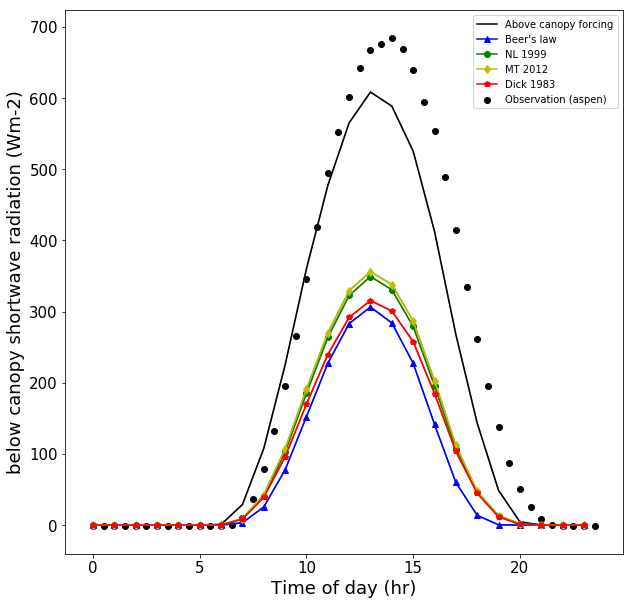

In [63]:
# create plot with four different below canopy shortwave radiation parameterizations
Radiation_Combine_Graph = Radiation_Combine.plot(legend=False)

Radiation_Combine_Graph.plot(Radiation_Combine['Above canopy forcing'], color='k', marker='')
Radiation_Combine_Graph.plot(Radiation_Combine["Beer's law"],color='b', marker='^') 
Radiation_Combine_Graph.plot(Radiation_Combine['NL 1999'], color='g', marker='o')
Radiation_Combine_Graph.plot(Radiation_Combine['MT 2012'], color='y', marker='d')
Radiation_Combine_Graph.plot(Radiation_Combine['Dick 1983'], color='r', marker='p')

Radiation_Combine_Graph.tick_params(labelsize = 15)
# plot scatter with x='xvals', y='Observation (aspen)'
d = Radiation_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black')

# add x, y label
Radiation_Combine_Graph.set_xlabel("Time of day (hr)", fontsize=18)
Radiation_Combine_Graph.set_ylabel("below canopy shortwave radiation (Wm-2)", fontsize=18)

handles, labels = Radiation_Combine_Graph.get_legend_handles_labels()
# show up the legend
Radiation_Combine_Graph.legend(handles[5:11], labels[5:11])
jtplot.figsize(x=10, y=10)

#### 4.8) Get hour of day output of the four below canopy shortwave radiation parameterization for the specific period (2006-10-01~2007-09-30)

In [38]:
BeersLaw_hour = calc_short_radiation(results_BeersLaw, "2006-10-01", "2007-09-30")
NL_scatter_hour = calc_short_radiation(results_NL_scatter, "2006-10-01", "2007-09-30")
UEB_2stream_hour = calc_short_radiation(results_UEB_2stream, "2006-10-01", "2007-09-30")
CLM_2stream_hour = calc_short_radiation(results_CLM_2stream, "2006-10-01", "2007-09-30")
forcing_data = calc_forcing(forcing, "2006-10-01", "2007-09-30")

#### 4.9) Combine the below canopy shortwave radiation parameterizations into a single Pandas Dataframe  (2006-10-01~2007-09-30)

In [39]:
# Combine each below canopy shortwave radiation parameterizations
Radiation_Combine = pd.concat([BeersLaw_hour, NL_scatter_hour, UEB_2stream_hour, CLM_2stream_hour, forcing_data], axis=1)
# add label 
Radiation_Combine.columns = ["Beer's law", "NL 1999", "MT 2012", "Dick 1983", "Above canopy forcing"]

#### 4.10) Get hour of day forcing of the four below canopy shortwave radiation parameterizations for the specific period  (2006-10-01~2007-09-30)

In [40]:
xvals, df_gp_hr = obs_radiation(Val_eddyFlux, "2006-10-01", "2007-09-30")

#### 4.11) Plotting output of four different below canopy shortwave radiation parameterizations, forcing data and observation data  (2006-10-01~2007-09-30)

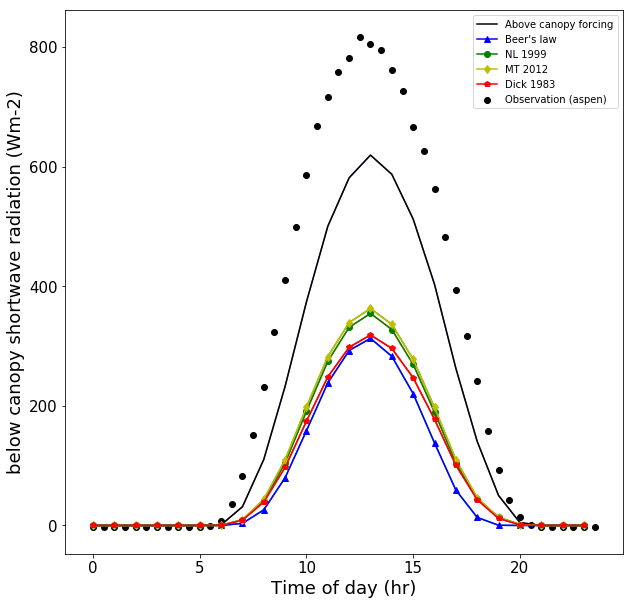

In [41]:
# create plot with four different below canopy shortwave radiation parameterizations
Radiation_Combine_Graph = Radiation_Combine.plot(legend=False)

Radiation_Combine_Graph.plot(Radiation_Combine['Above canopy forcing'], color='k', marker='')
Radiation_Combine_Graph.plot(Radiation_Combine["Beer's law"],color='b', marker='^') 
Radiation_Combine_Graph.plot(Radiation_Combine['NL 1999'], color='g', marker='o')
Radiation_Combine_Graph.plot(Radiation_Combine['MT 2012'], color='y', marker='d')
Radiation_Combine_Graph.plot(Radiation_Combine['Dick 1983'], color='r', marker='p')

Radiation_Combine_Graph.tick_params(labelsize = 15)
# plot scatter with x='xvals', y='Observation (aspen)'
d = Radiation_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black')

# add x, y label
Radiation_Combine_Graph.set_xlabel("Time of day (hr)", fontsize=18)
Radiation_Combine_Graph.set_ylabel("below canopy shortwave radiation (Wm-2)", fontsize=18)

handles, labels = Radiation_Combine_Graph.get_legend_handles_labels()
# show up the legend
Radiation_Combine_Graph.legend(handles[5:11], labels[5:11])
jtplot.figsize(x=10, y=10)

#### 4.12) Get hour of day output of the four below canopy shortwave radiation parameterization for the specific period (200710-01~2008-09-30)

In [42]:
BeersLaw_hour = calc_short_radiation(results_BeersLaw, "2007-10-01", "2008-09-30")
NL_scatter_hour = calc_short_radiation(results_NL_scatter, "2007-10-01", "2008-09-30")
UEB_2stream_hour = calc_short_radiation(results_UEB_2stream, "2007-10-01", "2008-09-30")
CLM_2stream_hour = calc_short_radiation(results_CLM_2stream, "2007-10-01", "2008-09-30")
forcing_data = calc_forcing(forcing, "2007-10-01", "2008-09-30")

#### 4.13) Combine the below canopy shortwave radiation parameterizations into a single Pandas Dataframe  (2007-10-01~2008-09-30)

In [43]:
# Combine each below canopy shortwave radiation parameterizations
Radiation_Combine = pd.concat([BeersLaw_hour, NL_scatter_hour, UEB_2stream_hour, CLM_2stream_hour, forcing_data], axis=1)
# add label 
Radiation_Combine.columns = ["Beer's law", "NL 1999", "MT 2012", "Dick 1983", "Above canopy forcing"]

#### 4.14) Get hour of day forcing of the four below canopy shortwave radiation parameterizations for the specific period  (2007-10-01~2008-09-30)

In [44]:
xvals, df_gp_hr = obs_radiation(Val_eddyFlux, "2007-10-01", "2008-09-30")

#### 4.15) Plotting output of four different below canopy shortwave radiation parameterizations, forcing data and observation data  (2007-10-01~2008-09-30)

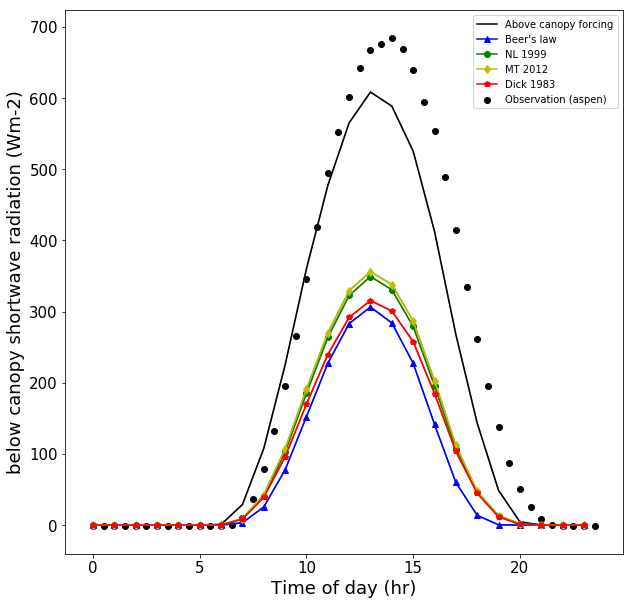

In [45]:
# create plot with four different below canopy shortwave radiation parameterizations
Radiation_Combine_Graph = Radiation_Combine.plot(legend=False)

Radiation_Combine_Graph.plot(Radiation_Combine['Above canopy forcing'], color='k', marker='')
Radiation_Combine_Graph.plot(Radiation_Combine["Beer's law"],color='b', marker='^') 
Radiation_Combine_Graph.plot(Radiation_Combine['NL 1999'], color='g', marker='o')
Radiation_Combine_Graph.plot(Radiation_Combine['MT 2012'], color='y', marker='d')
Radiation_Combine_Graph.plot(Radiation_Combine['Dick 1983'], color='r', marker='p')

Radiation_Combine_Graph.tick_params(labelsize = 15)
# plot scatter with x='xvals', y='Observation (aspen)'
d = Radiation_Combine_Graph.scatter(xvals, df_gp_hr['Observation (aspen)'], color='black')

# add x, y label
Radiation_Combine_Graph.set_xlabel("Time of day (hr)", fontsize=18)
Radiation_Combine_Graph.set_ylabel("below canopy shortwave radiation (Wm-2)", fontsize=18)

handles, labels = Radiation_Combine_Graph.get_legend_handles_labels()
# show up the legend
Radiation_Combine_Graph.legend(handles[5:11], labels[5:11])
jtplot.figsize(x=10, y=10)

#### 4.16) Validation between the observation and simulation data.

In [46]:
from pysumma.Validation import validation

In [47]:
# defind simulation data
BeersLaw_simulation = Radiation_Combine ["Beer's law"]
NL_scatter_simulation = Radiation_Combine ["NL 1999"]
UEB_2stream_simulation = Radiation_Combine ["MT 2012"]
CLM_2stream_simulation = Radiation_Combine ["Dick 1983"]

In [48]:
# defind observation data
obs = df_gp_hr.groupby('level_0').mean()
observation_data = obs['Observation (aspen)']

In [49]:
# analyze validtation between BeersLaw simulation and observation data.
validation.analysis(observation_data, BeersLaw_simulation)

Mean Absolute Error: 139.329953
Mean Squared Error: 42866.848257
Root Mean Squared Error: 207.043107


In [50]:
# analyze validtation between NL_scatter simulation and observation data.
validation.analysis(observation_data, NL_scatter_simulation)

Mean Absolute Error: 120.844318
Mean Squared Error: 32363.721417
Root Mean Squared Error: 179.899198


In [51]:
# analyze validtation between UEB_2stream simulation and observation data.
validation.analysis(observation_data, UEB_2stream_simulation)

Mean Absolute Error: 118.305257
Mean Squared Error: 30991.273654
Root Mean Squared Error: 176.043386


In [52]:
# analyze validtation between CLM_2stream_ simulation and observation data.
validation.analysis(observation_data, CLM_2stream_simulation)

Mean Absolute Error: 128.422462
Mean Squared Error: 36960.812268
Root Mean Squared Error: 192.251950


## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:
* This plotting compares the model simulations of downwelling shortwave radiation below the vegetation canopy with below-canopy shortwave radiation observations for the aspen site in Reynolds Mountain East. 
* The results in Figure 1 show that the choice of canopy shortwave parameterization with default parameters can result in differences in estimates of below-canopy shortwave radiation of around 50 W m22 at the Aspen site in Reynolds Mountain East

## 6. Post a renewal Model Instance, SUMMA output, and notebook back to Hydroshare

In [62]:
from pysumma.hydroshare import hydroshare
hs = hydroshare.hydroshare()

Successfully established a connection with HydroShare


In [55]:
# zip a renewal SUMMA Model Instance to upload on HydroShare
import shutil, os
archive_name = os.path.expanduser(os.path.join('~', os.getcwd() +'/' + instance +'_new'))
root_dir = os.path.expanduser(os.path.join('~', os.getcwd() +'/' + instance))
shutil.make_archive(archive_name, 'zip', root_dir)
Model_instance = os.getcwd() +'/' + instance +'_new.zip'

In [56]:
# set meta data such as abstract, title, keywords, rtype to create a new SUMMA Model Instance
title = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East_new'
abstract = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East(new)'
keywords = ('SUMMA', 'Hydrologic Model', 'Reynolds Mountain East', 'Below Canopy Shortwave Radiation Parameterization')
rtype = 'ModelInstanceResource'
fpath = Model_instance,
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [57]:
# create a new SUMMA Model Instance on HydroShare
resource_id1 = hs.createHydroShareResource(title=title, content_files=fpath, keywords=keywords, abstract=abstract, resource_type='modelinstanceresource', public=False)

Resource Created Successfully                           


In [58]:
# set meta data such as abstract, title, keywords, rtype to create a SUMMA Composite Resource that contains SUMMA Model instance, output, and notebook.
title = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East_new'
abstract = 'Sensitivity to Below Canopy Shortwave Radiation Parameterization of SUMMA Model in Aspen stand at Reynolds Mountain East(new)'
keywords = ('SUMMA', 'Hydrologic Model', 'Reynolds Mountain East', 'Below Canopy Shortwave Radiation Parameterization')
rtype = 'CompositeResource'
files = out_file1, out_file2, out_file3, out_file4
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [59]:
# create a new SUMMA Composite Resource on HydroShare
resource_id2 = hs.createHydroShareResource(title=title, content_files=files, keywords=keywords, abstract=abstract, resource_type='compositeresource', public=False)

Resource Created Successfully                           
Successfully Added Content Files                      


In [60]:
# add a new SUMMA Model Instance to a new SUMMA Composite Resource.
hs.addContentToExistingResource(resource_id2, [Model_instance])

Successfully Added Content Files                      


#### Save this notebook file and add the notebook to the resource

In [61]:
# add a new notebook to a new SUMMA Composite Resource.
npath = os.getcwd() +'/SummaModel_ReynoldsAspenStand_ShortwaveRadiation.ipynb'
# check the resource id on HS that created.
hs.addContentToExistingResource(resource_id2, [npath])

Successfully Added Content Files                      
